In [1]:
import torch, os, pickle
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(43, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
#         self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        
        # Our final linear layer will define our output
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
#         x = self.conv5(x, edge_index)
#         x = x.relu()
        x = global_add_pool(x, batch)  ## Miles says use sumpool

        x = self.lin1(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

case='test_all_smass'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
print(len(data))

criterion = torch.nn.MSELoss()
n_epochs=100
from torch_geometric.loader import DataLoader
train_loader=DataLoader(data, batch_size=64, shuffle=1)


769


In [14]:
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, MultiplicativeLR
warm_up=5
lrs=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
s1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2)
s2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [s1,s2], milestones=[10])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)

model.train()
for epoch in range(n_epochs):
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
    #         accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad()
    if epoch<warm_up:    
        s1.step()
#         lrs.append(s1.get_last_lr())
    else:
        scheduler.step()
        s2.step()
        
    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])

In [11]:
class warmup_exp():
    def __init__(self,optimizer, g_up=2, g_down=0.95, warmup=5, period=5, eta_min=1e-5):
        self.warmup=warmup
        self.s1 = ExponentialLR(optimizer, gamma=g_up)
        self.s2 = ExponentialLR(optimizer, gamma=g_down)
    def step(self, epoch):
        if epoch<self.warmup:    
            self.s1.step()
        else:
            self.s2.step()

In [12]:
class warmup_expcos():
    def __init__(self,optimizer, g_up=2, g_down=0.95, warmup=5, period=5, eta_min=1e-5):
        self.warmup=warmup
        self.s1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=g_up)
        self.s2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=g_down)
        #eta_min cannot be bigger than or equal to initial learning rate
        self.cos = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, period, eta_min=eta_min) 
    def step(self, epoch):
        if epoch<self.warmup:    
            self.s1.step()
        else:
            self.cos.step()
            self.s2.step()
    


In [13]:
lrs=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
sch=warmup_exp(optimizer)
# sch=warmup_expcos(optimizer)

# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [s1,s2], milestones=[10])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)

model.train()
for epoch in range(n_epochs):
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        optimizer.step() 
        optimizer.zero_grad()
        scheduler.step(epoch)
    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])

NameError: name 'ExponentialLR' is not defined

In [ ]:
plt.plot(lrs)

In [17]:
lrs[1]/lrs[0], lrs[3]/lrs[2]

(8192.0, 8192.0)

In [ ]:
lrs=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
model.train()
for epoch in range(n_epochs):
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
    #         accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad()

In [144]:
optimizer.state_dict()['param_groups'][0]['lr']

0.0011460500150447146

In [145]:
# help(torch.optim.lr_scheduler)

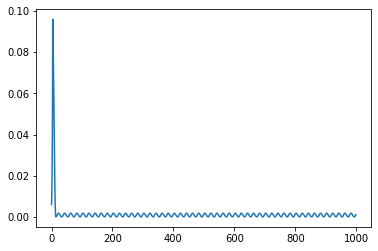

In [146]:
plt.plot(lrs)

In [140]:
min(lrs)

9.5e-06

In [2]:
from dev.lr_schedule import warmup_exp, warmup_expcos 

In [3]:
def get_lr_schedule(s):
    schedule  = s

    import dev.lr_schedule as lr_module

    schedule_class = getattr(lr_module, schedule)

    return schedule_class

scheduler=get_lr_schedule('warmup_exp')

In [4]:
lrs=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# sch=warmup_exp(optimizer, g_up=2)
# sch=warmup_expcos(optimizer)
scheduler=scheduler(optimizer)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [s1,s2], milestones=[10])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)

model.train()
for epoch in range(n_epochs):
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        optimizer.step() 
        optimizer.zero_grad()
#     sch.step(epoch)
    scheduler.step(epoch)

    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])

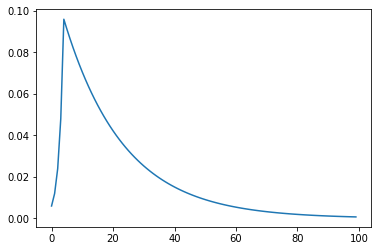

In [5]:
plt.plot(lrs)

In [53]:
lrs[1]/lrs[0]

79.37147732541435

In [2]:
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, MultiplicativeLR
